# 1. get data <a id="a"></a>

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import auc,classification_report, precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.model_selection import GridSearchCV

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
seed(42)
%matplotlib inline

Using TensorFlow backend.


In [2]:
def autoencoder_x(train_x, val_x):
    '''get autoencoder for x'''
    x_train_norm = preprocessing.MinMaxScaler().fit_transform(train_x.values)
    x_val_norm = preprocessing.MinMaxScaler().fit_transform(val_x.values)
    train = hidden_representation.predict(x_train_norm)
    val = hidden_representation.predict(x_val_norm)
    return train, val


def tsne_plot(x1, y1):
    '''plot t-sne graph'''
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1==0), 0], X_t[np.where(y1==0),1], 
               marker='o',color='g', alpha=0.8, label='Non fraud')
    plt.scatter(X_t[np.where(y1==1), 0], X_t[np.where(y1==1),1], 
               marker='o',color='r', alpha=0.8, label='fraud')
    
    plt.legend(loc='best')
    plt.show()
    
    
def rp_curve(recall, precision):
    '''plot recall-precision curve'''
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.figure(figsize=(15,8))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve:')
    
def plot_gridsearch_cv(labels, scores):
    '''plot gridsearch cv score'''
    plt.figure(figsize=(15,8))
    n_lines = len(labels)
    
    for i in range(n_lines):
        plt.plot(scores[i],label=labels[i])
    
    plt.title("CV scores for different hyper-parameter",fontsize=20)
    plt.xticks([0,1,2,3,4])
    plt.legend()
    plt.show()

In [3]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data["Time"] = data["Time"].apply(lambda x:x/3600%24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. auto-encoder

We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

In [5]:
## input layer
input_layer = Input(shape=(data.shape[1]-1,))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(data.shape[1]-1, activation='relu')(decoded)

In [6]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [7]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y==0], x_scale[y==1]

In [8]:
#trian this model
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], batch_size=256,
               epochs = 30, shuffle=True, validation_split=0.20)

Train on 1600 samples, validate on 400 samples
Epoch 1/30
1600/1600 [==============================] - 1s 567us/step - loss: 0.7886 - val_loss: 0.5451
Epoch 2/30
1600/1600 [==============================] - 0s 27us/step - loss: 0.5008 - val_loss: 0.3261
Epoch 3/30
1600/1600 [==============================] - 0s 25us/step - loss: 0.3081 - val_loss: 0.2215
Epoch 4/30
1600/1600 [==============================] - 0s 25us/step - loss: 0.2117 - val_loss: 0.1636
Epoch 5/30
1600/1600 [==============================] - 0s 25us/step - loss: 0.1716 - val_loss: 0.1755
Epoch 6/30
1600/1600 [==============================] - 0s 25us/step - loss: 0.1830 - val_loss: 0.1405
Epoch 7/30
1600/1600 [==============================] - 0s 24us/step - loss: 0.1448 - val_loss: 0.1326
Epoch 8/30
1600/1600 [==============================] - 0s 25us/step - loss: 0.1587 - val_loss: 0.1349
Epoch 9/30
1600/1600 [==============================] - 0s 25us/step - loss: 0.1478 - val_loss: 0.1350
Epoch 10/30
1600/1600 [==

In [9]:
# obtain the latent representations
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [10]:
norm_hid_rep = hidden_representation.predict(x_norm)[:3000]
fraud_hid_rep = hidden_representation.predict(x_fraud)

Here we can visualize latent representation by t-sne.

In [11]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

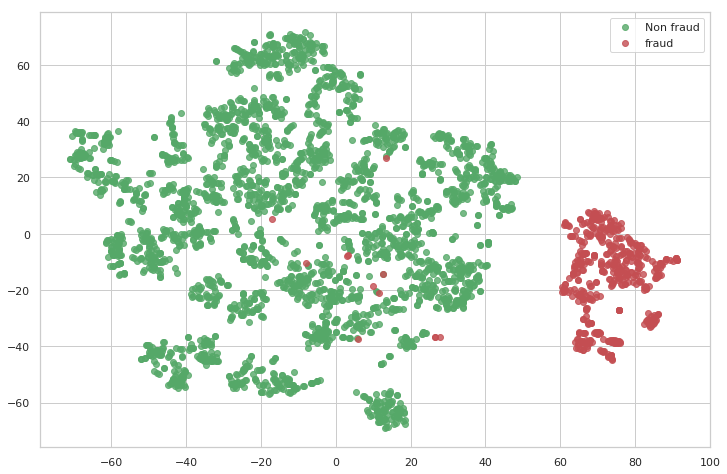

In [12]:
tsne_plot(rep_x, rep_y)

we can observe that now fraud and non-fraud transactions are pretty visibile and are linearly separable.

# Linear Classifier evaluation

Now we use a simple linear classifer on this dataset.

In [13]:
train_x = pd.read_csv('data/X_train.csv')
val_x = pd.read_csv('data/X_test.csv')
train_y = pd.read_csv('data/y_train.csv', header=None)[0]
val_y = pd.read_csv('data/y_test.csv', header=None)[0]

In [14]:
train_x, val_x = autoencoder_x(train_x, val_x)

Now we tune the hyper-parameter for the model

In [15]:
#tuning
parameters = {'solver':('lbfgs', 'liblinear'),'C':[0.2,0.5,1,10]}
lg = LogisticRegression()
clf0 = GridSearchCV(lg, parameters, cv=5)
clf0.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ('lbfgs', 'liblinear'), 'C': [0.2, 0.5, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

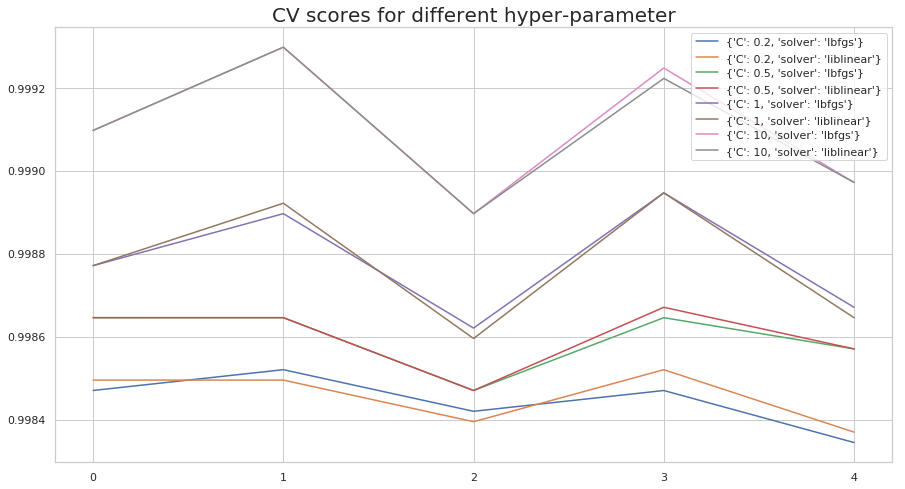

In [16]:
#get labels and scores to plot gridsearch cv score for comparing performance
labels = clf0.cv_results_['params']
labels

scores = []
for i in range(8):
    s_part = []
    for cv in range(5):
        s = str('split' + str(cv) + "_test_score")
        s_part.append(clf0.cv_results_[s][i])
    scores.append(s_part)
scores


plot_gridsearch_cv(labels,scores)

By this graph, we can choose the best hyper-parameter to trian the model.

In [17]:
clf = LogisticRegression(**clf0.best_params_).fit(train_x, train_y)
pred_y = clf.predict(val_x)

print('Classification Report: ')
print(classification_report(val_y, pred_y))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.89      0.32      0.47       146

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.94      0.66      0.74     85443
weighted avg       1.00      1.00      1.00     85443



We can draw the precision recall curve to evaluate it.

In [18]:
score_y = clf.predict_proba(val_x)[:,1]

In [19]:
precision, recall, _ = precision_recall_curve(val_y, score_y)

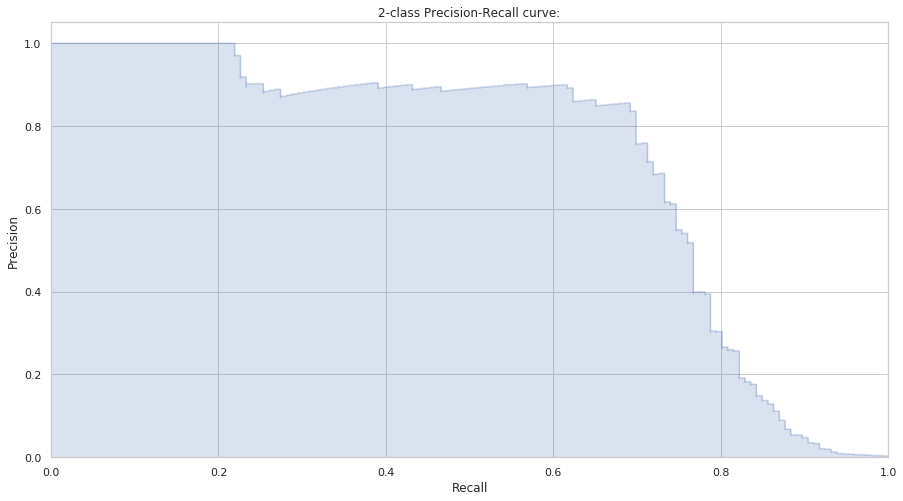

In [20]:
rp_curve(recall, precision)

In [21]:
print("The AUC of precision-recall curve is {:.3f}".format(auc(recall,precision)))

The AUC of precision-recall curve is 0.717
